<a href="https://colab.research.google.com/github/ayulockin/LossLandscape/blob/master/ResNet20v1_Aug_Val_Acc_Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
# Other imports
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set()

from tqdm.notebook import tqdm_notebook
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [4]:
!mkdir ResNet20v1_CIFAR10_Aug
!gsutil -m cp -r gs://losslandscape/ResNet20v1_CIFAR10_Aug_Diff_Inits/resnet20v1-aug-diff-inits-*.h5 ResNet20v1_CIFAR10_Aug/

Copying gs://losslandscape/ResNet20v1_CIFAR10_Aug_Diff_Inits/resnet20v1-aug-diff-inits-5.h5...
Copying gs://losslandscape/ResNet20v1_CIFAR10_Aug_Diff_Inits/resnet20v1-aug-diff-inits-0.h5...
Copying gs://losslandscape/ResNet20v1_CIFAR10_Aug_Diff_Inits/resnet20v1-aug-diff-inits-6.h5...
Copying gs://losslandscape/ResNet20v1_CIFAR10_Aug_Diff_Inits/resnet20v1-aug-diff-inits-2.h5...
Copying gs://losslandscape/ResNet20v1_CIFAR10_Aug_Diff_Inits/resnet20v1-aug-diff-inits-3.h5...
Copying gs://losslandscape/ResNet20v1_CIFAR10_Aug_Diff_Inits/resnet20v1-aug-diff-inits-1.h5...
Copying gs://losslandscape/ResNet20v1_CIFAR10_Aug_Diff_Inits/resnet20v1-aug-diff-inits-7.h5...
Copying gs://losslandscape/ResNet20v1_CIFAR10_Aug_Diff_Inits/resnet20v1-aug-diff-inits-4.h5...
Copying gs://losslandscape/ResNet20v1_CIFAR10_Aug_Diff_Inits/resnet20v1-aug-diff-inits-8.h5...
Copying gs://losslandscape/ResNet20v1_CIFAR10_Aug_Diff_Inits/resnet20v1-aug-diff-inits-9.h5...
- [10/10 files][ 69.4 MiB/ 69.4 MiB] 100% Done    

In [3]:
model_ckpts = os.listdir('ResNet20v1_CIFAR10_Aug')
print(len(model_ckpts))

10


In [4]:
# Load the training set of CIFAR10
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

def normalize(image, label):
    return tf.image.convert_image_dtype(image, tf.float32), label


test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
) 

In [5]:
# Choose a single model randomly and load it up
model_ckpt = model_ckpts[int(np.random.choice(len(model_ckpts), 1))]
single_model = model = tf.keras.models.load_model('/content/ResNet20v1_CIFAR10_Aug/' + model_ckpt)

# Evaluate it
accuracy_single_model = single_model.evaluate(test_ds)[1] * 100
accuracy_single_model

313/313 [==============================] - 4s 13ms/step - loss: 0.4588 - accuracy: 0.8659


86.58999800682068

In [6]:
# Create list to models with different solutions
members = [tf.keras.models.load_model('/content/ResNet20v1_CIFAR10_Aug/' + model_ckpts[i]) 
                            for i in range(len(model_ckpts))]
len(members)

10

Reference: https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/

In [7]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members):
	# make predictions
	yhats = [model.predict(x_test/255.) for model in members]
	yhats = np.array(yhats)
	# sum across ensemble members
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	result = np.argmax(summed, axis=1)
	return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members):
    accuracy_list = []
    for n_members in tqdm_notebook(range(2, 12, 2)):
        # select a subset of members
        subset = members[:n_members]
        print(len(subset))
        # make prediction
        yhat = ensemble_predictions(subset)
        # calculate accuracy
        accuracy_list.append(100*accuracy_score(y_test, yhat))

    return accuracy_list

In [8]:
# Run the ensembles
accuracy_list = evaluate_n_members(members)

2
4
6
8
10



In [9]:
accuracy_list.insert(0, accuracy_single_model)
rng = [i for i in range(0, 12, 2)]

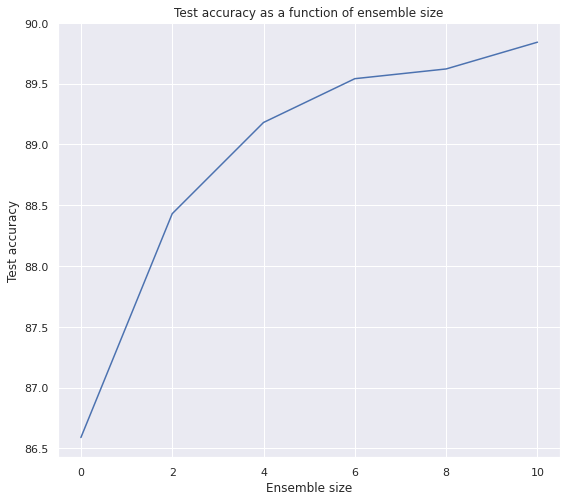

In [12]:
plt.figure(figsize=(9,8))
plt.plot(rng, accuracy_list)
plt.title("Test accuracy as a function of ensemble size")
plt.xlabel("Ensemble size")
plt.ylabel("Test accuracy")
plt.savefig('ensemble_func.png')

In [12]:
%%capture 
pip install wandb 

In [13]:
import wandb
wandb.login()

True

In [14]:
wandb.init(project='loss-landscape', id='resnet20v1_aug_ensemble_func-1')
wandb.log({'ensemble_function': wandb.Image('ensemble_func.png')})